# Simple neural network on each feature 

### the aim is to compare the different resulting confusion matrices and see which features are more meaningful

In [1]:
import pandas as pd
from pathlib import Path
from typing import Dict, List
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers

In [2]:
# Modelling

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.linear_model import LogisticRegression

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image

In [63]:
TRAIN_VAL_DATA_PATH = '../../data/train_val_Enc_Counters.parquet'
df: pd.DataFrame = pd.read_parquet(TRAIN_VAL_DATA_PATH) 
# df = df.astype({f"f_{i}": "category" for i in range(2, 33)})

In [15]:
from utils.normalized_cross_entropy_loss import normalized_cross_entropy_loss

In [64]:
features = []
for x in range(1,80):
    features.append("f_{}".format(x))

features

['f_1',
 'f_2',
 'f_3',
 'f_4',
 'f_5',
 'f_6',
 'f_7',
 'f_8',
 'f_9',
 'f_10',
 'f_11',
 'f_12',
 'f_13',
 'f_14',
 'f_15',
 'f_16',
 'f_17',
 'f_18',
 'f_19',
 'f_20',
 'f_21',
 'f_22',
 'f_23',
 'f_24',
 'f_25',
 'f_26',
 'f_27',
 'f_28',
 'f_29',
 'f_30',
 'f_31',
 'f_32',
 'f_33',
 'f_34',
 'f_35',
 'f_36',
 'f_37',
 'f_38',
 'f_39',
 'f_40',
 'f_41',
 'f_42',
 'f_43',
 'f_44',
 'f_45',
 'f_46',
 'f_47',
 'f_48',
 'f_49',
 'f_50',
 'f_51',
 'f_52',
 'f_53',
 'f_54',
 'f_55',
 'f_56',
 'f_57',
 'f_58',
 'f_59',
 'f_60',
 'f_61',
 'f_62',
 'f_63',
 'f_64',
 'f_65',
 'f_66',
 'f_67',
 'f_68',
 'f_69',
 'f_70',
 'f_71',
 'f_72',
 'f_73',
 'f_74',
 'f_75',
 'f_76',
 'f_77',
 'f_78',
 'f_79']

In [65]:
for f in features:
    if df[f].isna().sum() > 0:
        mean = df[f].mean()
        df[f].fillna(value=mean, inplace=True)
df

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79,is_clicked,is_installed
0,2541162,51,29,4,123,4,2334,0,0,6,...,7.0,3.0,3.000005,30.000053,7.000012,0.0,0.0,0.0,False,False
1,2541260,49,87,0,451,0,3625,0,4,0,...,0.0,0.0,3.000005,30.000053,7.000012,0.0,0.0,0.0,False,False
2,2541318,51,87,0,451,4,3625,0,4,6,...,0.0,0.0,1.000002,30.000053,7.000012,0.0,0.0,0.0,False,False
3,2541770,64,57,4,148,4,4793,0,4,4,...,3.0,2.0,3.000005,30.000053,7.000012,0.0,0.0,0.0,False,False
4,2542002,62,87,0,614,0,100,0,0,5,...,0.0,0.0,3.000005,30.000053,7.000012,0.0,0.0,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3485847,1988041,62,55,4,56,4,2934,0,4,5,...,0.0,0.0,0.000000,6.000010,0.000000,0.0,0.0,0.0,False,False
3485848,1988471,45,117,4,235,3,4169,0,1,1,...,2.0,0.0,0.000000,30.000053,7.000012,0.0,0.0,0.0,False,False
3485849,1988651,56,114,4,191,4,155,0,4,0,...,2.0,0.0,3.000005,30.000053,7.000012,0.0,0.0,0.0,False,False
3485850,1988792,48,135,4,136,2,1488,0,1,5,...,4.0,3.0,0.000000,30.000053,7.000012,0.0,0.0,0.0,False,False


## Data Split

In [66]:
threshold_day = 63

In [67]:
df = df.astype({'f_1': 'int'})

booleans = range(33, 41+1)
for i in booleans:
    df = df.astype({'f_{}'.format(i): 'int'})

df = df.astype({'is_clicked': 'int'})
df = df.astype({'is_installed': 'int'})

In [68]:
X_train = df[df["f_1"]<threshold_day].drop(columns=['is_clicked','is_installed'])
y_train = df[df["f_1"]<threshold_day]
y_train = y_train[['is_clicked','is_installed']]

X_val = df[df["f_1"]>=threshold_day].drop(columns=['is_clicked','is_installed'])
y_val = df[df["f_1"]>=threshold_day]
y_val = y_val[['is_clicked','is_installed']]

In [69]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2967905, 80), (2967905, 2), (517947, 80), (517947, 2))

## Preprocessing

In [70]:
to_delete = ['f_0','f_7','f_27','f_28','f_29']
X_train = X_train.drop(columns=to_delete)
X_val = X_val.drop(columns=to_delete)

In [11]:
X_train.head(5)

,f_1,f_2,f_3,f_4,f_5,f_6,f_8,f_9,f_10,f_11,...,f_70,f_71,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79
0,51,29,4,123,4,2334,0,6,2,22,...,2.828680,2.0,7.0,3.0,3.000005,30.000053,7.000012,0.0,0.0,0.0
1,49,87,0,451,0,3625,4,0,0,3,...,0.000000,0.0,0.0,0.0,3.000005,30.000053,7.000012,0.0,0.0,0.0
2,51,87,0,451,4,3625,4,6,2,1,...,0.000000,0.0,0.0,0.0,1.000002,30.000053,7.000012,0.0,0.0,0.0
3,64,57,4,148,4,4793,4,4,0,8,...,1.598379,0.0,3.0,2.0,3.000005,30.000053,7.000012,0.0,0.0,0.0
4,62,87,0,614,0,100,0,5,2,1,...,0.000000,0.0,0.0,0.0,3.000005,30.000053,7.000012,0.0,0.0,0.0


In [12]:
X_val.head(5)

,f_1,f_2,f_3,f_4,f_5,f_6,f_8,f_9,f_10,f_11,...,f_70,f_71,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79
10,65,131,4,376,3,3261,2,1,2,17,...,2.627060,1.0,8.0,6.0,3.000005,30.000053,7.000012,0.0,0.0,0.0
37,65,47,2,385,3,3221,0,6,0,2,...,0.735807,0.0,0.0,0.0,0.000000,22.000040,0.000000,0.0,0.0,0.0
85,65,87,0,614,0,100,4,6,0,8,...,0.000000,0.0,1.0,0.0,0.000000,30.000053,5.000009,0.0,0.0,0.0
92,65,117,2,506,3,2959,4,6,0,2,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
95,66,29,4,552,4,2334,1,1,2,1,...,2.929505,0.0,3.0,1.0,0.000000,30.000053,7.000012,0.0,0.0,0.0


## Training

### Model

In [71]:
seed = 1234


In [14]:
def build_model(n_features, elastic_lambda):
    input_layer = tfkl.Input(shape=(n_features,), name='input')

    x = tfkl.Dense(
        units=64,
        activation='swish',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda)
    )(input_layer)
    x = tfkl.Dropout(0.1, seed=seed)(x)
    
    out = tfkl.Dense(
        units=1,
        activation='sigmoid',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        #kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda),
        name='OutputLayer'
    )(x)

    model = tfk.Model(inputs=input_layer, outputs=out, name='model')
    # Compile the model
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    # Return the model
    return model

In [129]:
model = build_model(1, 1e-5)

## An example

In [15]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder = OneHotEncoder()
df_encoded = encoder.fit_transform([f])

In [28]:
f = "f_23"

In [197]:
cat = []
for i in range(57):
    cat.append(i)

In [198]:
cat

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56]

In [210]:
encoder=OneHotEncoder(categories=[cat])
encoded=encoder.fit_transform(X_train[[f]])
encoded_val=encoder.fit_transform(X_val[[f]])

In [213]:
encoded=encoded.toarray()
encoded_val=encoded_val.toarray()

In [209]:
encoded_val.shape, X_val[f].shape

((), (244983,))

In [51]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
      print(class_series)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

In [52]:
class_weight=generate_class_weights(y_train['is_installed'])

In [88]:
y_train['is_installed'].to_numpy()

array([0, 0, 0, ..., 0, 0, 1])

In [53]:
class_weight

{0: 0.6059447810732668, 1: 2.8597198226037297}

In [203]:
model=build_model(57, 1e-5)

In [214]:
history = model.fit(encoded,
                    y_train["is_installed"],
                    batch_size=128,
                    epochs=5,
                    class_weight=class_weight,
                    validation_data = (encoded_val,y_val["is_installed"]),
                    callbacks = [tfk.callbacks.EarlyStopping(monitor = 'val_loss',mode = 'max', patience = 15, restore_best_weights=True)]
).history

Epoch 1/5
25320/25320 [==============================] - 67s 2ms/step - loss: 0.5594 - accuracy: 0.6471 - val_loss: 0.5486 - val_accuracy: 0.6822
Epoch 2/5
25320/25320 [==============================] - 60s 2ms/step - loss: 0.5576 - accuracy: 0.6459 - val_loss: 0.5614 - val_accuracy: 0.6662
Epoch 3/5
25320/25320 [==============================] - 59s 2ms/step - loss: 0.5574 - accuracy: 0.6468 - val_loss: 0.5534 - val_accuracy: 0.6638
Epoch 4/5
25320/25320 [==============================] - 59s 2ms/step - loss: 0.5573 - accuracy: 0.6462 - val_loss: 0.5425 - val_accuracy: 0.6852
Epoch 5/5
25320/25320 [==============================] - 59s 2ms/step - loss: 0.5573 - accuracy: 0.6473 - val_loss: 0.5426 - val_accuracy: 0.6663


In [216]:
predictions=model.predict(encoded_val)

7656/7656 [==============================] - 10s 1ms/step


In [217]:
predictions[predictions>0.5]=1
predictions[predictions<=0.5]=0

In [218]:
cm=confusion_matrix(y_val["is_installed"], predictions)

## All features, 1:1

In [104]:
for f in to_delete:
    if f in features:
        features.remove(f)

features

['f_1',
 'f_2',
 'f_3',
 'f_4',
 'f_5',
 'f_6',
 'f_8',
 'f_9',
 'f_10',
 'f_11',
 'f_12',
 'f_13',
 'f_14',
 'f_15',
 'f_16',
 'f_17',
 'f_18',
 'f_19',
 'f_20',
 'f_21',
 'f_22',
 'f_23',
 'f_24',
 'f_25',
 'f_26',
 'f_30',
 'f_31',
 'f_32',
 'f_33',
 'f_34',
 'f_35',
 'f_36',
 'f_37',
 'f_38',
 'f_39',
 'f_40',
 'f_41',
 'f_42',
 'f_43',
 'f_44',
 'f_45',
 'f_46',
 'f_47',
 'f_48',
 'f_49',
 'f_50',
 'f_51',
 'f_52',
 'f_53',
 'f_54',
 'f_55',
 'f_56',
 'f_57',
 'f_58',
 'f_59',
 'f_60',
 'f_61',
 'f_62',
 'f_63',
 'f_64',
 'f_65',
 'f_66',
 'f_67',
 'f_68',
 'f_69',
 'f_70',
 'f_71',
 'f_72',
 'f_73',
 'f_74',
 'f_75',
 'f_76',
 'f_77',
 'f_78',
 'f_79']

In [105]:
numerical_columns: List[str] = [f"f_{i}" for i in range(42, 80)]
numerical_columns

['f_42',
 'f_43',
 'f_44',
 'f_45',
 'f_46',
 'f_47',
 'f_48',
 'f_49',
 'f_50',
 'f_51',
 'f_52',
 'f_53',
 'f_54',
 'f_55',
 'f_56',
 'f_57',
 'f_58',
 'f_59',
 'f_60',
 'f_61',
 'f_62',
 'f_63',
 'f_64',
 'f_65',
 'f_66',
 'f_67',
 'f_68',
 'f_69',
 'f_70',
 'f_71',
 'f_72',
 'f_73',
 'f_74',
 'f_75',
 'f_76',
 'f_77',
 'f_78',
 'f_79']

In [108]:
file = open("NN_confusion_file.csv", "x")
file.write( "{}, {}, {}, {}, {}, {}, {} \n".format("Feature", "Accuracy", "f1", "True Negative (0,0)", "False Positive (0,1)", "False Negative (1,0)", "True Positive (1,1)"))

109

In [111]:

accuracies = []
f1s =[]

for f in numerical_columns:
    print("***Training on {}***".format(f))
    model = build_model(1, 1e-5)
    history = model.fit(X_train[[f]],
                    y_train["is_installed"],
                    batch_size=128,
                    epochs=5,
                    class_weight=class_weight,
                    validation_data = (X_val[[f]],y_val["is_installed"]))
    predictions = model.predict(X_val[[f]])
    predictions[predictions>0.5]=1
    predictions[predictions<=0.5]=0
    
    f1 = f1_score(y_val['is_installed'], predictions)
    accuracy = np.sum(predictions==y_val['is_installed'])/len(predictions)*100

    cm = confusion_matrix(y_val["is_installed"], predictions)
    file.write( "{}, {}, {}, {}, {}, {}, {} \n".format(f, accuracy, f1, cm[0,0], cm[0,1], cm[1,0], cm[1,1]))
    
    accuracies.append(accuracy)
    f1s.append(f1)

file.close()

***Training on f_42***
Epoch 1/5
25320/25320 [==============================] - 60s 2ms/step - loss: 13.6100 - accuracy: 0.4872 - val_loss: 0.6945 - val_accuracy: 0.5711
Epoch 2/5
25320/25320 [==============================] - 59s 2ms/step - loss: 0.6908 - accuracy: 0.5824 - val_loss: 0.6849 - val_accuracy: 0.6111
Epoch 3/5
25320/25320 [==============================] - 60s 2ms/step - loss: 0.6908 - accuracy: 0.5879 - val_loss: 0.6885 - val_accuracy: 0.6261
Epoch 4/5
25320/25320 [==============================] - 60s 2ms/step - loss: 0.6908 - accuracy: 0.5866 - val_loss: 0.6874 - val_accuracy: 0.6111
Epoch 5/5
7656/7656 [==============================] - 10s 1ms/step
***Training on f_43***
Epoch 1/5
25320/25320 [==============================] - 62s 2ms/step - loss: 0.7089 - accuracy: 0.5083 - val_loss: 0.6855 - val_accuracy: 0.4533
Epoch 2/5
25320/25320 [==============================] - 60s 2ms/step - loss: 0.6893 - accuracy: 0.5181 - val_loss: 0.6853 - val_accuracy: 0.4524
Epoch 3/5

In [71]:
baseline = 0.9607

entropies = np.array(entropies)
print("{} models can beat the entropy baseline".format(len(entropies[entropies < baseline])))
print("{} models can't beat the entropy baseline".format(len(entropies[entropies > baseline])))

0 models can beat the entropy baseline
75 models can't beat the entropy baseline


# All features categorical

In [19]:
categorical_columns: List[str] = [f"f_{i}" for i in range(2, 33)]

In [24]:
to_delete = ['f_0','f_7','f_27','f_28','f_29']
categorical_columns = [x for x in categorical_columns if x not in to_delete]

In [25]:
categorical_columns

['f_2',
 'f_3',
 'f_4',
 'f_5',
 'f_6',
 'f_8',
 'f_9',
 'f_10',
 'f_11',
 'f_12',
 'f_13',
 'f_14',
 'f_15',
 'f_16',
 'f_17',
 'f_18',
 'f_19',
 'f_20',
 'f_21',
 'f_22',
 'f_23',
 'f_24',
 'f_25',
 'f_26',
 'f_30',
 'f_31',
 'f_32']

In [26]:
file = open("NN_categoricals.csv", "x")
file.write( "{}, {}, {}, {}, {}, {}, {} \n".format("Feature", "Accuracy", "f1", "True Negative (0,0)", "False Positive (0,1)", "False Negative (1,0)", "True Positive (1,1)"))

109

In [27]:
accuracies = []
f1s =[]

for f in categorical_columns:
    print("***Training on {}***".format(f))
    dim=X_train[f].max()+1
    if (X_val[f].max()+1)>dim:
        dim=X_val[f].max()+1
    if dim<150:
        cat = []
        for i in range(dim):
            cat.append(i)
        encoder=OneHotEncoder(categories=[cat])
        encoded=encoder.fit_transform(X_train[[f]])
        encoded_val=encoder.fit_transform(X_val[[f]])
        encoded=encoded.toarray()
        encoded_val=encoded_val.toarray()
        
        model = build_model(dim, 1e-5)
        history = model.fit(encoded,
                        y_train["is_installed"],
                        batch_size=128,
                        epochs=5,
                        class_weight=class_weight,
                        validation_data = (encoded_val,y_val["is_installed"]))
        predictions = model.predict(encoded_val)
        predictions[predictions>0.5]=1
        predictions[predictions<=0.5]=0
        
        f1 = f1_score(y_val['is_installed'], predictions)
        accuracy = np.sum(predictions==y_val['is_installed'])/len(predictions)*100

        cm = confusion_matrix(y_val["is_installed"], predictions)
        file.write( "{}, {}, {}, {}, {}, {}, {} \n".format(f, accuracy, f1, cm[0,0], cm[0,1], cm[1,0], cm[1,1]))
        
        accuracies.append(accuracy)
        f1s.append(f1)

file.close()

***Training on f_2***
Epoch 1/5
25320/25320 [==============================] - 66s 3ms/step - loss: 0.5356 - accuracy: 0.6430 - val_loss: 0.5525 - val_accuracy: 0.5916
Epoch 2/5
25320/25320 [==============================] - 64s 3ms/step - loss: 0.5330 - accuracy: 0.6396 - val_loss: 0.5494 - val_accuracy: 0.6798
Epoch 3/5
25320/25320 [==============================] - 64s 3ms/step - loss: 0.5326 - accuracy: 0.6391 - val_loss: 0.5425 - val_accuracy: 0.6772
Epoch 4/5
25320/25320 [==============================] - 70s 3ms/step - loss: 0.5325 - accuracy: 0.6405 - val_loss: 0.5473 - val_accuracy: 0.5949
Epoch 5/5
7656/7656 [==============================] - 9s 1ms/step
***Training on f_3***
Epoch 1/5
25320/25320 [==============================] - 58s 2ms/step - loss: 0.6748 - accuracy: 0.3271 - val_loss: 0.6637 - val_accuracy: 0.3598
Epoch 2/5
25320/25320 [==============================] - 57s 2ms/step - loss: 0.6730 - accuracy: 0.3214 - val_loss: 0.6533 - val_accuracy: 0.3598
Epoch 3/5
253

#### Example: f_23 -> clearly shows that without class weights NNs don't work

In [29]:
f='f_23'
dim=X_train[f].max()+1
if (X_val[f].max()+1)>dim:
    dim=X_val[f].max()+1
if dim<150:
    cat = []
    for i in range(dim):
        cat.append(i)
    encoder=OneHotEncoder(categories=[cat])
    encoded=encoder.fit_transform(X_train[[f]])
    encoded_val=encoder.fit_transform(X_val[[f]])
    encoded=encoded.toarray()
    encoded_val=encoded_val.toarray()
    
    model = build_model(dim, 1e-5)
    history = model.fit(encoded,
                    y_train["is_installed"],
                    batch_size=128,
                    epochs=5,
                    #class_weight=class_weight,
                    validation_data = (encoded_val,y_val["is_installed"]))
    predictions = model.predict(encoded_val)
    predictions[predictions>0.5]=1
    predictions[predictions<=0.5]=0

Epoch 1/5
25320/25320 [==============================] - 121s 5ms/step - loss: 0.4738 - accuracy: 0.8206 - val_loss: 0.4466 - val_accuracy: 0.8369
Epoch 2/5
25320/25320 [==============================] - 112s 4ms/step - loss: 0.4627 - accuracy: 0.8252 - val_loss: 0.4467 - val_accuracy: 0.8369
Epoch 3/5
25320/25320 [==============================] - 103s 4ms/step - loss: 0.4626 - accuracy: 0.8252 - val_loss: 0.4452 - val_accuracy: 0.8369
Epoch 4/5
25320/25320 [==============================] - 106s 4ms/step - loss: 0.4625 - accuracy: 0.8252 - val_loss: 0.4462 - val_accuracy: 0.8369
Epoch 5/5
7656/7656 [==============================] - 18s 2ms/step


In [30]:
cm=confusion_matrix(y_val["is_installed"], predictions)

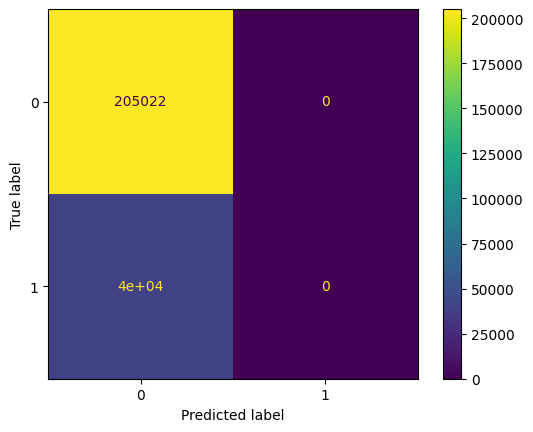

In [31]:
ConfusionMatrixDisplay(cm).plot()

## All features binaries

In [54]:
binary_columns: List[str] = [f"f_{i}" for i in range(33, 42)]

In [55]:
file = open("NN_binary.csv", "x")
file.write( "{}, {}, {}, {}, {}, {}, {} \n".format("Feature", "Accuracy", "f1", "True Negative (0,0)", "False Positive (0,1)", "False Negative (1,0)", "True Positive (1,1)"))

109

In [57]:
accuracies = []
f1s =[]

for f in binary_columns:
    print("***Training on {}***".format(f))
    model = build_model(1, 1e-5)
    history = model.fit(X_train[[f]],
                    y_train["is_installed"],
                    batch_size=128,
                    epochs=5,
                    class_weight=class_weight,
                    validation_data = (X_val[[f]],y_val["is_installed"]))
    predictions = model.predict(X_val[[f]])
    predictions[predictions>0.5]=1
    predictions[predictions<=0.5]=0
    
    f1 = f1_score(y_val['is_installed'], predictions)
    accuracy = np.sum(predictions==y_val['is_installed'])/len(predictions)*100

    cm = confusion_matrix(y_val["is_installed"], predictions)
    file.write( "{}, {}, {}, {}, {}, {}, {} \n".format(f, accuracy, f1, cm[0,0], cm[0,1], cm[1,0], cm[1,1]))
    
    accuracies.append(accuracy)
    f1s.append(f1)

file.close()

***Training on f_33***
Epoch 1/5
25320/25320 [==============================] - 83s 3ms/step - loss: 0.6947 - accuracy: 0.5626 - val_loss: 0.6915 - val_accuracy: 0.7836
Epoch 2/5
25320/25320 [==============================] - 80s 3ms/step - loss: 0.6931 - accuracy: 0.5515 - val_loss: 0.6865 - val_accuracy: 0.7836
Epoch 3/5
25320/25320 [==============================] - 83s 3ms/step - loss: 0.6931 - accuracy: 0.5607 - val_loss: 0.6944 - val_accuracy: 0.7836
Epoch 4/5
25320/25320 [==============================] - 85s 3ms/step - loss: 0.6931 - accuracy: 0.5502 - val_loss: 0.6914 - val_accuracy: 0.7836
Epoch 5/5
7656/7656 [==============================] - 12s 1ms/step
***Training on f_34***
Epoch 1/5
25320/25320 [==============================] - 76s 3ms/step - loss: 0.7010 - accuracy: 0.5248 - val_loss: 0.7030 - val_accuracy: 0.4844
Epoch 2/5
25320/25320 [==============================] - 78s 3ms/step - loss: 0.6923 - accuracy: 0.4965 - val_loss: 0.6980 - val_accuracy: 0.4844
Epoch 3/5


In [48]:
predictions = model.predict(X_val[f])
predictions[predictions>0.5]=1
predictions[predictions<=0.5]=0

7656/7656 [==============================] - 12s 2ms/step


In [49]:
cm=confusion_matrix(y_val["is_installed"], predictions)

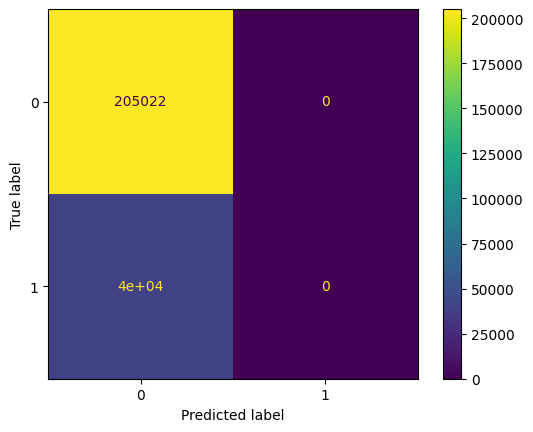

In [50]:
ConfusionMatrixDisplay(cm).plot()

### A look at the best one

In [62]:
lr = LogisticRegression(random_state=0, class_weight='balanced').fit(X_train[["f_42"]], y_train["is_installed"])
results_installed = lr.predict_proba(X_val[["f_42"]])
predictions = lr.predict(X_val[["f_42"]])

In [63]:
cm=confusion_matrix(y_val["is_installed"], predictions)

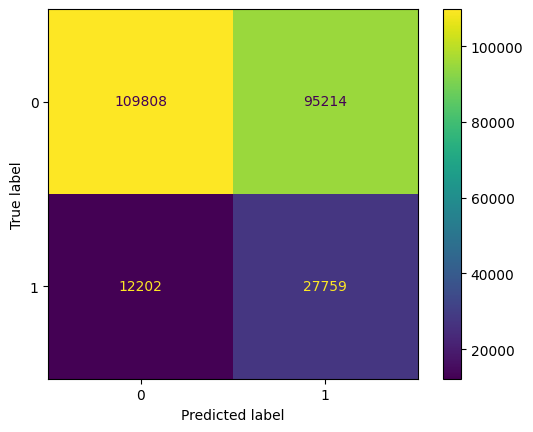

In [134]:
ConfusionMatrixDisplay(cm).plot()

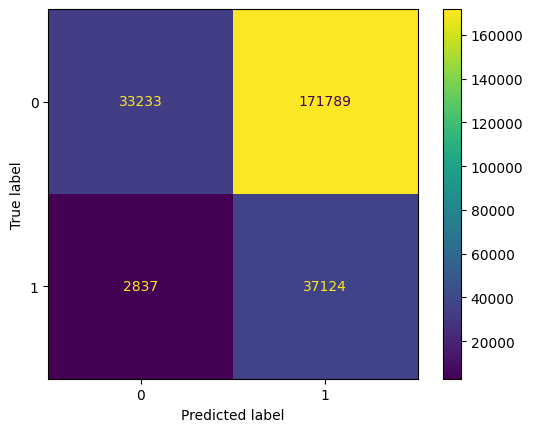

In [127]:
ConfusionMatrixDisplay(cm).plot()

**Confusion matrix of f_20 as numerical**

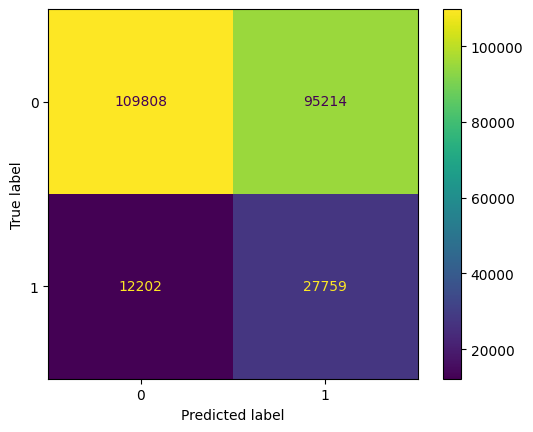

In [138]:
ConfusionMatrixDisplay(cm).plot()

**Confusion matrix of 20 as categorical**

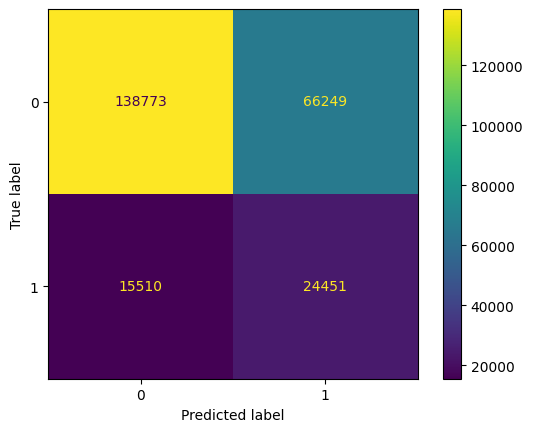

In [219]:
ConfusionMatrixDisplay(cm).plot()